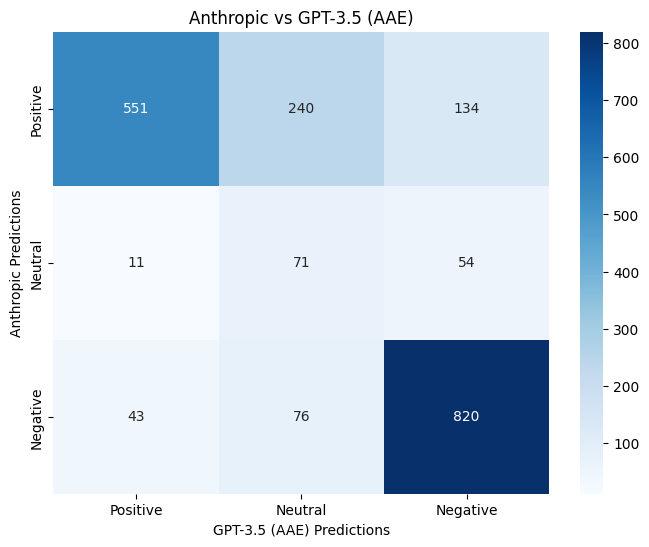

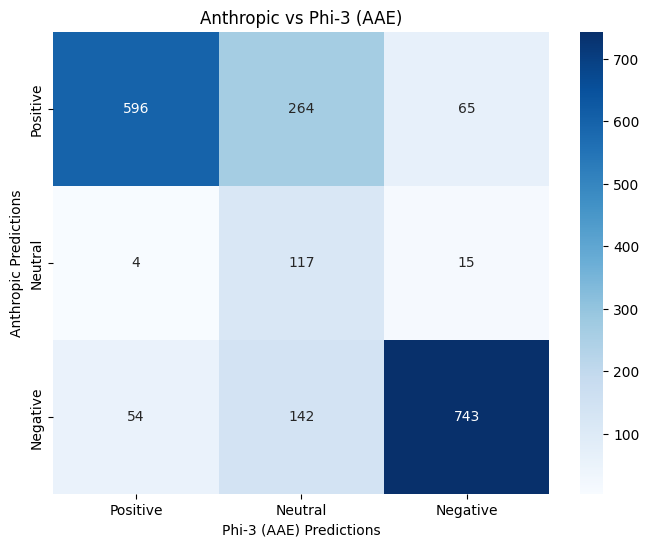

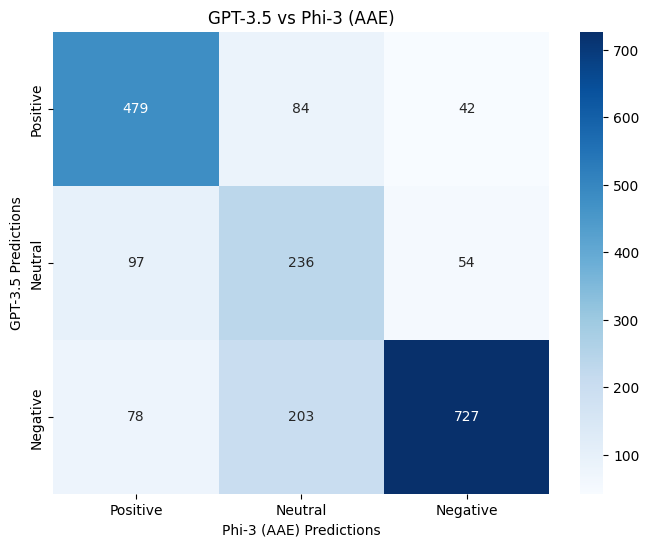

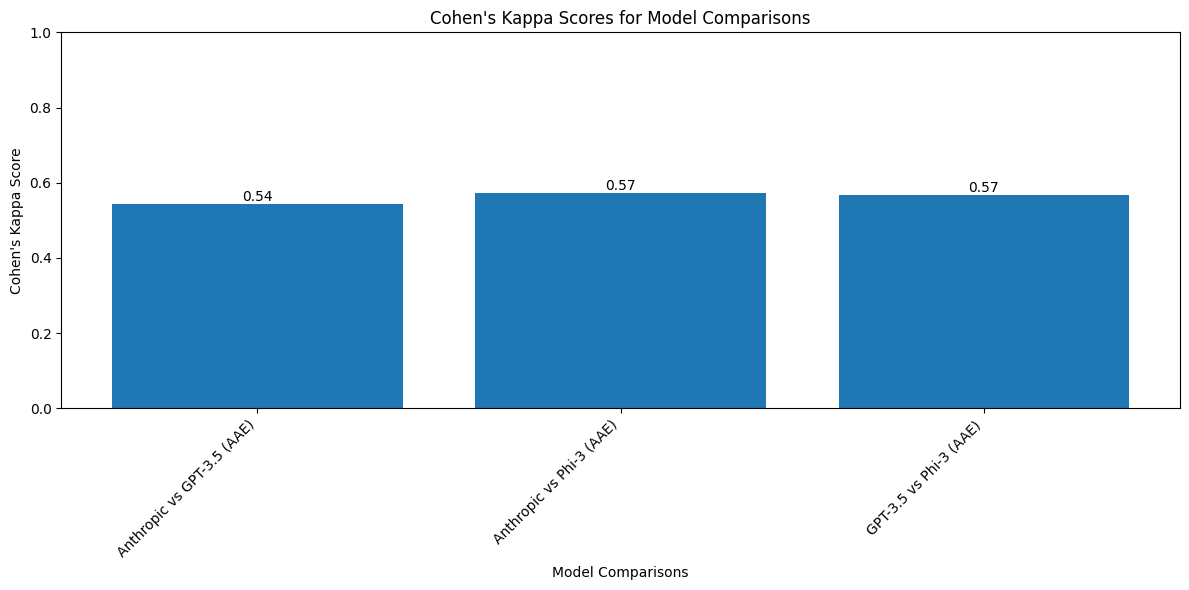

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Load the datasets
anthropic_aae = pd.read_csv('./labeled/anthropic_Haiku-aae-labels.csv')
#anthropic_sae = pd.read_csv('./labeled/anthropic_Haiku-sae-labels.csv')
#anthropic_aae_from_sae = pd.read_csv('./labeled/anthropic_Haiku-AAE_from_SAE_updated.csv')
gpt_aae = pd.read_csv('./labeled/gpt-3.5-aae-labels.csv')
#gpt_sae = pd.read_csv('./labeled/gpt-3.5-sae-labels.csv')
#gpt_aae_from_sae = pd.read_csv('./labeled/gpt-3.5-AAE_from_SAE_updated.csv')
phi_aae = pd.read_csv('./labeled/Phi-3-aae-labels.csv')
#phi_sae = pd.read_csv('./labeled/Phi-3-sae-labels.csv')
#phi_aae_from_sae = pd.read_csv('Phi-3-AAE_from_SAE_updated.csv')

def calculate_agreement(df1, df2):
    # Ensure the DataFrames are aligned
    common_indices = df1.index.intersection(df2.index)
    df1 = df1.loc[common_indices]
    df2 = df2.loc[common_indices]
    
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(df1['sentiment'], df2['sentiment'])
    
    # Calculate confusion matrix
    cm = confusion_matrix(df1['sentiment'], df2['sentiment'], labels=['Positive', 'Neutral', 'Negative'])
    
    return kappa, cm

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
    plt.title(title)
    
    # Extract model names from the title
    model_names = title.split(' vs ')
    
    plt.xlabel(f'{model_names[1]} Predictions')
    plt.ylabel(f'{model_names[0]} Predictions')
    plt.show()
    
def plot_kappa_scores(kappa_scores):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(kappa_scores.keys(), kappa_scores.values())
    plt.title("Cohen's Kappa Scores for Model Comparisons")
    plt.xlabel('Model Comparisons')
    plt.ylabel("Cohen's Kappa Score")
    plt.ylim(0, 1)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Calculate agreement metrics
kappa_scores = {}
comparisons = [
    (anthropic_aae, gpt_aae, 'Anthropic vs GPT-3.5 (AAE)'),
    (anthropic_aae, phi_aae, 'Anthropic vs Phi-3 (AAE)'),
    (gpt_aae, phi_aae, 'GPT-3.5 vs Phi-3 (AAE)')
]

for df1, df2, title in comparisons:
    kappa, cm = calculate_agreement(df1, df2)
    kappa_scores[title] = kappa
    plot_confusion_matrix(cm, title)

# Plot Kappa scores
plot_kappa_scores(kappa_scores)

## Cohen's Kappa statistical measure of inter-raters agreement (Here LLMs that rating/classifying the sentiment). It's the agreement between two raters of categories/class an item belongs to.

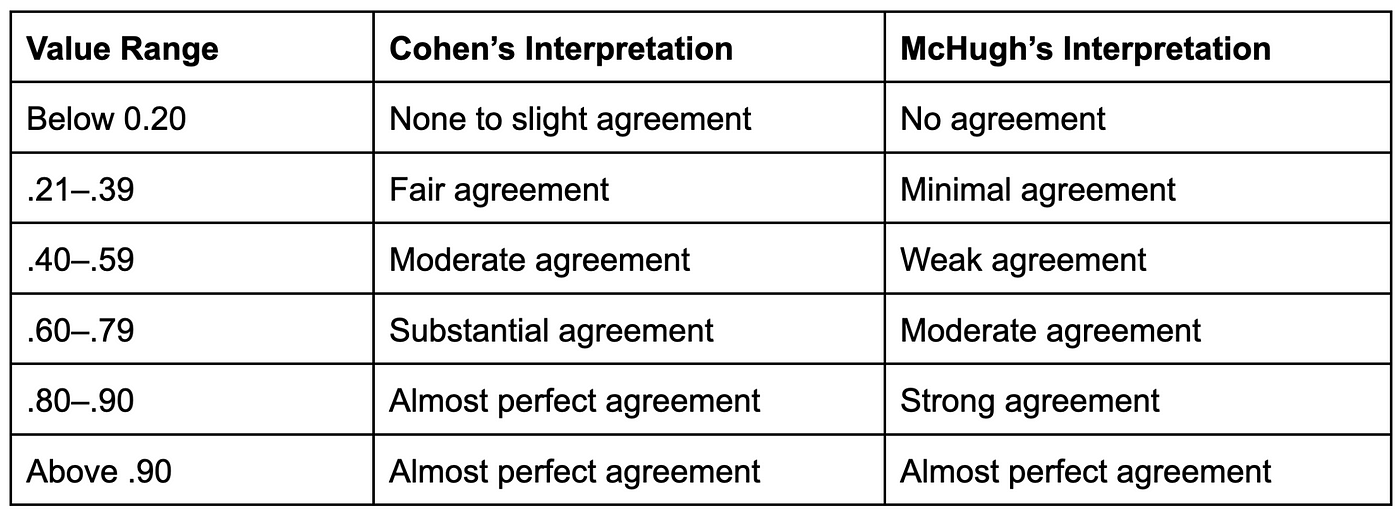

## How many cases more than two are NOT the same? (for each index of sentences in the datasets, how many senteces are there were all three models outputted a distinct sentiment?)

In other words, number of sentences with **Absolute disagreement** between models.

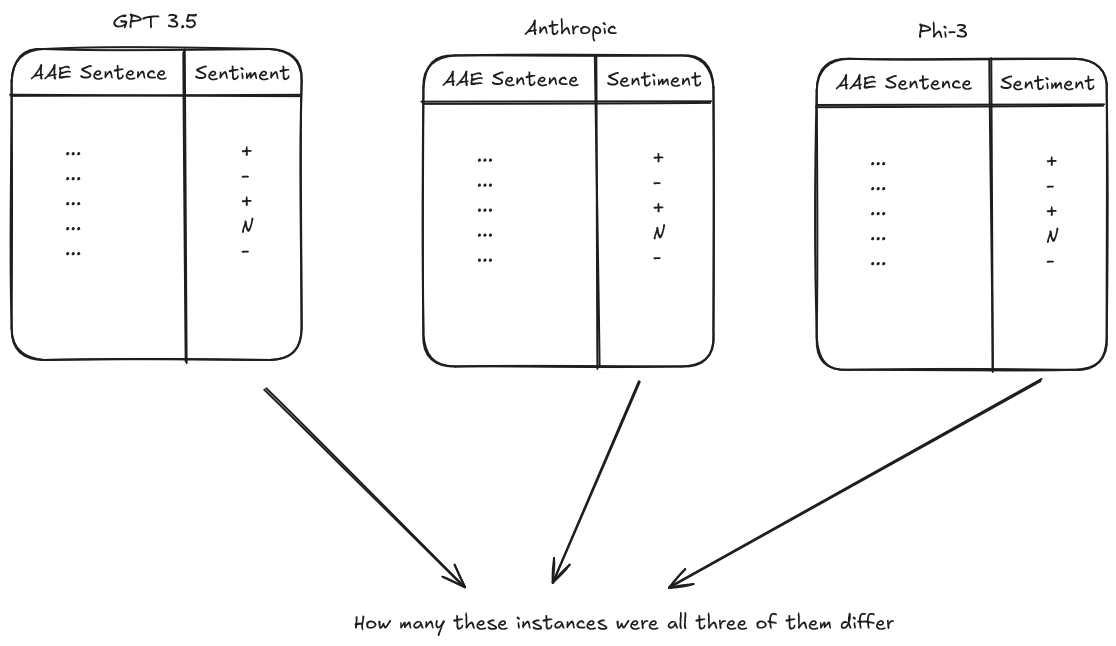

In [71]:
def create_combined_df(Sentences, GPT_Labels, Anthropic_Labels, Phi_3_Labels):
    return pd.concat([Sentences, GPT_Labels, Anthropic_Labels, Phi_3_Labels], axis=1)

combined = create_combined_df(Sentences=gpt_aae.rename(columns={'sentence':'AAE-sentence'})['AAE-sentence'], GPT_Labels=gpt_aae.rename(columns={'sentiment':'GPT-3.5-sentiment'})['GPT-3.5-sentiment'], 
                                           Anthropic_Labels=anthropic_aae.rename(columns={'sentiment':'Anthropic-sentiment'})['Anthropic-sentiment'], 
                                           Phi_3_Labels=phi_aae.rename(columns={'sentiment':'Phi-3-sentiment'})['Phi-3-sentiment'])
    

Extracting out instances where all three models disagree
```python
mask = (df['GPT-3.5-sentiment'] != df['Anthropic-sentiment']) & \
       (df['GPT-3.5-sentiment'] != df['Phi-3-sentiment']) & \
       (df['Anthropic-sentiment'] != df['Phi-3-sentiment'])
```

In [72]:
def get_absolute_disagreement_df(df):
    mask = (df['GPT-3.5-sentiment'] == df['Anthropic-sentiment']) & \
       (df['GPT-3.5-sentiment'] == df['Phi-3-sentiment']) & \
       (df['Anthropic-sentiment'] == df['Phi-3-sentiment'])
    df_disagreements = df[mask]
    return df_disagreements

In [73]:
absolute_disagreement = get_absolute_disagreement_df(combined)
absolute_disagreement.head()

,AAE-sentence,GPT-3.5-sentiment,Anthropic-sentiment,Phi-3-sentiment
0,Bitch cant get shit from me but bubble gum nd ...,Negative,Negative,Negative
1,@islandboi_B yes that's what's up. Nothin like...,Positive,Positive,Positive
2,Mixed huh !? Those black ass knees and elbows ...,Negative,Negative,Negative
4,It took for a whole stranger to tell me he PRO...,Positive,Positive,Positive
5,I'm the type that would walk thru the fire to ...,Positive,Positive,Positive


In [74]:
absolute_disagreement.shape

(1215, 4)

## Why is the abosulte disagreement happening? Let's check the sentiment one-by-one and label it manually.

In [30]:
absolute_disagreement['Manual labeled Sentiment'] = ''

/local/home/furquanh/tmp/ipykernel_4106555/4145311325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  absolute_disagreement['Manual labeled Sentiment'] = ''


In [31]:
def manual_labeling(df):
    for index, row in df.iterrows():
        print(f"Sentence: {row['AAE-sentence']}")
        sentiment = input("Enter the sentiment (Positive, Neutral, Negative): ")
        df.at[index, 'Manual labeled Sentiment'] = sentiment
    return df

Sentence: For all of you that needed some WINTER WEATHER...ENJOY!  The rest of us will just ride it out. Yall SNOW people just SAT DOWN AND HUSH!!

Enter the sentiment (Positive, Neutral, Negative):  Negative

Sentence: Relationships r wut u make it so dont be such a bitch about thing and relationships will last longer.

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @LoVEme_ai look around 2:13 a.m Myself jumped up and was like self!? Itold myself huh? Myself sed.bitch yu 4gt to call ai.! myself sed damn!

Enter the sentiment (Positive, Neutral, Negative):  Negative

Sentence: @GritzN_Gravy right I need to cheer up because he's in a better place and people blaming honey cocaine

Enter the sentiment (Positive, Neutral, Negative):  Positive

Sentence: after school traffic at washington went down also soon as it got hot in the school year nigga left tech early to get to washington

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: LOL ion wnt ha to wea noo panties 2ma wen she cum ova onna real

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @ILoveAvis i know it do..i remember the last time i went..i constantly fell down..i thought i was gonna break my ankle in the process lol

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: It seems like Everybody child calling me aunt Kisha or they thinking I'm their big sister who don't gives two fucks about em lol

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @rouseyG_boss I understand dat don't write me a SA lmao but if u invited her u paying!  did this happen to u?

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: why do i feel like this classroom is set up like some final destination type shit ? lol

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: I don't catch sub tweets no more cause I rarely scroll down my TL anymore I just tweet and get off lol

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: I.keep on falling in love with you , sometimes I love you sometimes you make me blue

Enter the sentiment (Positive, Neutral, Negative):  Positive

Sentence: @naturalbeauti93 oooo. Where you in school at I forgot . I'm ready to be in a hospital maaan

Enter the sentiment (Positive, Neutral, Negative):  Negative

Sentence: Don't ask questions you know the answers to, that's like not raising ya hand when you already have the answer to the question!

Enter the sentiment (Positive, Neutral, Negative):  Negative

Sentence: finally i woke up and smelt the coffee I understand that 2 women cant share 1 man

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: I swear terrill run MyLife &amp; I run his,  if he say don't go no were I sit my black ass ina crib &amp; same goes 4 him #ViceVers

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: I'm so high and this trying to smoke my cuz wild ass hell I'm about to ko on his ass

Enter the sentiment (Positive, Neutral, Negative):  Negative

Sentence: Because I'm human, I have my worries... I get stressed out, I deal with crap! Yes, I do pray, but I still have my tantrums! lolol

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Before u get your shine on you gotta get you r grind I ain't got time to be lying on my shit

Enter the sentiment (Positive, Neutral, Negative):  Positive

Sentence: Iknoo that ain't yhu with that dissin homie that's wy ii never replied just let em live on it

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Mane girl stop lien ii was eht the door the whole time nd ii could've gave yhu gas money

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: One thang my Daddy Taught me was to Lay da Dick Down Right da First Time ...

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: lmao...kg said lala tatste like honey nut cheerios!! honey nut have a bad after tatse when you burp....

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: #ImSingleBecause SHYD, I'm to young to be talkn about setting down with a female right now .

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Tf. Corduroy was goin on beyonce. Calling blue ivy. Blue bust, blue crayon. Etc. DTFL!

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: I wish he will just tell me how he feel so I can get a understanding were we at '

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @Xpinkkk__ oh its ah must cause he qot u on lick ima come ova dea one of these days when im nt dealinq with this dude

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Jus played 2 games of fun run...she kwit both times cuz i came n 1st place

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @KiKiPinkDiamond after I take my year first block them lights can do what the freak they want that's my entire purpose for going to dchool

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: lol she concerned of my sexuality ... im not bi ; why you want some ?

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Ups bet not act like no bitches. Im hittin da marriot up tomm. Hope they talkin bout sumthiinn #jobhunting

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @GwapsB4Niggas Hol Up Boo FREEZEEE! ! i juhh Askedd a questionnn!  Yeen gotta doo all dat reallyy! ! Cuhh Yhu cann gt it too

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: cut it bk on &amp;&amp; have a ass load of txt messages...epecially dem two from ya lil boo

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @AyeItsFlakaah and ur just mad u can't leave tthe frontyard without telling ur parents (:

Enter the sentiment (Positive, Neutral, Negative):  Negative

Sentence: Im drunk as hell all da boyz over my crib gettn fccd up Me Ivan Sean Monteith Success Ace boogie B Lewis BWard Lil Dee Donnie AJ Ebony &amp; etc

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: walkinnnn ah mission Ina half just for ah blunt lml dha shit I do too get highh

Enter the sentiment (Positive, Neutral, Negative):  Positive

Sentence: @envymeenvy lol she aint even ask to come homeee nd if she wouldve got in  trouble it would've been on my mama

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @SHAyR0CkStAr cause u said u was gone get it u had got my hopes up lol

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: When it gets there, I'll know its real cause you just said she don't know where you stay cause hoes don't come to the house!

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Put your pride aside and give me everything I want...Then I'll put all my wants aside and be content with what I have

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @LashantaRenee okay I hear yu now. Yu think somebody playin. Yu gone be da one choosing &amp; my nigga gone take ova!

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @Im_diffrent_btc  fasho u done cause it been three day lol frrfr i hope u aint trick me nikkik

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Ppl always saying I then change but wat they dnt knw I just grown up dats all

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @BETH_WIT_EM yea a lot of ppl and dude told me this was a slum night

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @KevLo_ at the end of the day there losing to Ravens as we speak after two Ray Rice fumbles lol and Ravens r jus solid

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: His coverage schemes were very good but an elite QB is gonna find a way to make plays regardless with no pressure.

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: What's good w Tyson Chandler he just wild out on Mahimi for no reason lol

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @KmobIv son I'm fakin crazy u kno damn well Nas &amp; Big top 5 and Im not into Pac or Em

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @fivefifths believe what you want, the history is there. when stricter guns laws are passed this year I will be sure to @ you haha

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: D'Antoni is gonna have to make a decision about having Dwight in under 4 or 5 minute mark, this shit is gettin serious lol

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: I need to see Larry Fitz w a decent QB again. But right now I would take AJ Green &amp; Megatron before him

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @SUPREMEdeem nah not no shit like that tho lol Im not no hot Blue Collar nigga u already know that ha

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Their are no blessings that can't turn into disasters !! And their are no disasters that can't turn into a blessing!!

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @Gawgeous__ yeah u no. That's probably why u AINT gave me non in so long ^=____^ #dead

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @juicyandprada I shoul was Fina open tha door n let yu out at yr stop

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: IGottaThing4..for guys who wud cum to chill at my hse ..watch movies..snack on sum..n not try to have SEX all da dam time!!#

Enter the sentiment (Positive, Neutral, Negative):  Negative

Sentence: Tryin to duck off so i can chill.....mr andre ass is not havin it lol

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: HE ASK ME Y I IGNORE HIM ALL DA TIME&lt;&lt;&lt;&lt; CAUSE I B ON MY GRIND

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: I anit never had nobody to show all the thing that u done showd me

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: ii BaLL muLtipLe wayz whicKh mean im athLetiK, uu Been hustLin foR 5 yeaRz whicKh mean uu Bad at it

Enter the sentiment (Positive, Neutral, Negative):  Positive

Sentence: They got me in here doin the south Dallas swag. I ain't do dat since last spring

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: I hope you, can feel me, when I say pay before you play with me

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Lmao dies but JE call it fat one day though real shit so it sunthing back there

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Lmaoaoa these weets but y am i in a car to get food lmao smt im missin everything

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Ik meeks better get tht tweet i sent ha fckn set it off hai havn ass lmao

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: * lmao , he said she looked over here twice she wants the d .

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: So I tried to get up... Really I did but its not happening right now... Ima still be live at church doe

Enter the sentiment (Positive, Neutral, Negative):  Negative

Sentence: @Dre4Stacks @trustory_ @asia_ariel @inclined2design @common_sens3 shit they better be done! It's only been 3 years!! Lol

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: My hunny shall be here soon...once again ion feel like leavin the house again so no beach tonight

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: SIS asked me How do it feel to go thru high school knowing somebody hates you...Shid its like I ain't tryin to please people fuck em lbs

Enter the sentiment (Positive, Neutral, Negative):  Positive

Sentence: @Prettyst_By_Far grrrr fuck Cali lol jk ain't going to no damn Cali &amp; was my sex good when we did it

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Da refs is definitely not on our side 2nyte but we still got dis game #CelticsNation

Enter the sentiment (Positive, Neutral, Negative):  Positive

Sentence: Some dude was about to break down at my job today cause he thought we sold out in his size lmao

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @IzaiahSantana Yeah just keep looking I know how that is it ain't easy at all

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Lmao The Only Person That Be Hitting My Jack In 2013 is My Bitch Lmao Embarrassing Brah

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @TraditionalRebl Lol damn, i must be going blind because i really couldn't tell it was you.

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: , Half Of These Females I Call My Sister I Hope They Really Is My Sister

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @inhalingTHEGOOD True. But Soon As I Play Some Lil Boosie On Dry Ahh. They Be Wanna Hate On A Nigga Lmao.. But Where Yu From

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @db_daddy yall niggas DRAWN yall all mi niggas n yall boutta mix n yall all mi manz

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @KissMi_Tattoos Oh Damn! Why that's  N'Dia running the water  I throught that was my mama Ctfu!

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @LetABrotherHit when you cut it back on all them texting gonna be load up on your fone

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Yu goin find sumbody just make sure in ur next relationship keep ya family out ur relationship

Enter the sentiment (Positive, Neutral, Negative):  Negative

Sentence: @whosduhboss Yes I think we should incorporate our outrage in the name.. so that the bandit knows we mean business

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Man sitting here thinkin bout wen all us got caught in s steamer on BUTTA bday my og came n got me n tooka

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: @lowend_original LMAO y folks think I'm Walkn around with a slew of dudes wanting me????

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: a simple minded female a drive u crazy bra but dem always b the ones we love the most..smh

Enter the sentiment (Positive, Neutral, Negative):  Positive

Sentence: too early to tweet plus i dont wanna wake her. dont want her mad at me. iloveyou.

Enter the sentiment (Positive, Neutral, Negative):  Positive

Sentence: But when it came to you, it was all real and sincere. Now your gone and ive moved on. What and how you felt is never my fault again.

Enter the sentiment (Positive, Neutral, Negative):  Negative

Sentence: @__Risaaa if  I didn't  have  to  work  I be  sleep  I don't  know how  u do  it  girl.

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: You say I'm always happy, and that I'm good at what I do, but what you'll never realize is, I'm a damn good actor too.

Enter the sentiment (Positive, Neutral, Negative):  Neutral

Sentence: Gonna write my fam soon man i miss my boy know he going hella crazy in there

Enter the sentiment (Positive, Neutral, Negative):  Neutral


# Now that we have manually labeled sentiment, let's check which model *agrees* with us the most

In [54]:
absolute_disagreement = pd.read_csv('./labeled/absolute-disagreement-manually-labeled.csv').drop(["Unnamed: 0","AAE-sentence"], axis=1)

In [55]:
absolute_disagreement.head()

,GPT-3.5-sentiment,Anthropic-sentiment,Phi-3-sentiment,Manual labeled Sentiment
0,Neutral,Negative,Positive,Negative
1,Neutral,Positive,Negative,Neutral
2,Negative,Positive,Neutral,Negative
3,Neutral,Negative,Positive,Positive
4,Negative,Positive,Neutral,Neutral


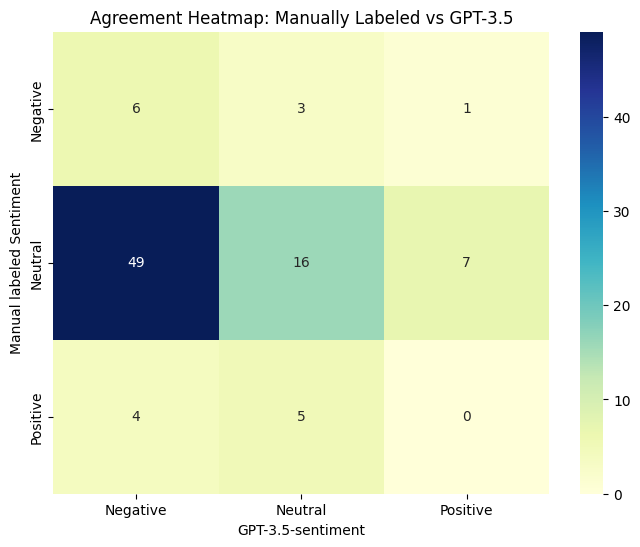

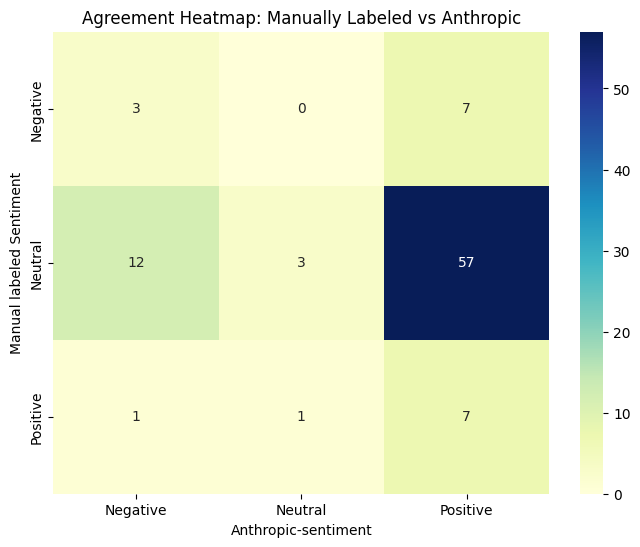

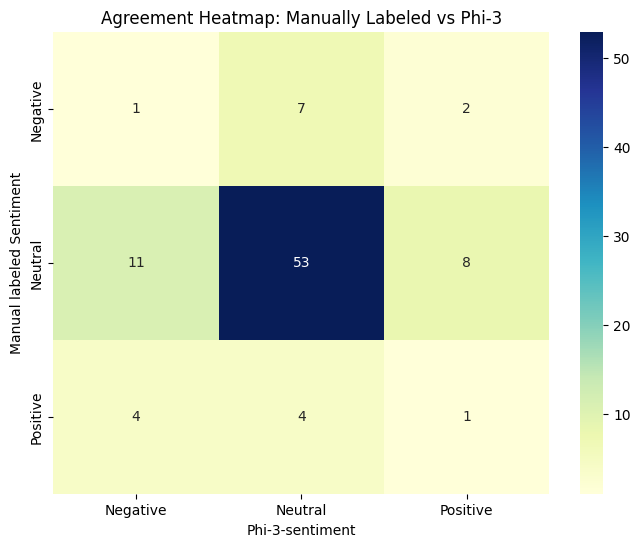

In [56]:
def plot_agreement_heatmap(df, col1, col2, title):
    agreement_matrix = pd.crosstab(df[col1], df[col2])
    plt.figure(figsize=(8, 6))
    sns.heatmap(agreement_matrix, annot=True, cmap='YlGnBu', cbar=True)
    plt.title(title)
    plt.xlabel(col2)
    plt.ylabel(col1)
    plt.show()

# Plot heatmaps of agreement between manual labels and each model's sentiments
plot_agreement_heatmap(absolute_disagreement, 'Manual labeled Sentiment', 'GPT-3.5-sentiment', 'Agreement Heatmap: Manually Labeled vs GPT-3.5')
plot_agreement_heatmap(absolute_disagreement, 'Manual labeled Sentiment', 'Anthropic-sentiment', 'Agreement Heatmap: Manually Labeled vs Anthropic')
plot_agreement_heatmap(absolute_disagreement, 'Manual labeled Sentiment', 'Phi-3-sentiment', 'Agreement Heatmap: Manually Labeled vs Phi-3')


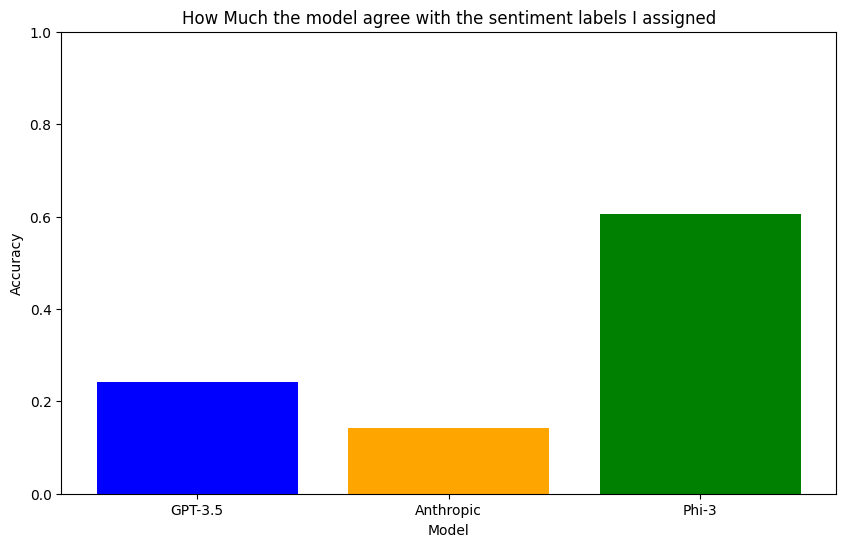

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# Calculate accuracy for each model
def calculate_accuracy(true_labels, predicted_labels):
    return accuracy_score(true_labels, predicted_labels)

# Compute accuracy scores
accuracies = {
    'GPT-3.5': calculate_accuracy(absolute_disagreement['Manual labeled Sentiment'],absolute_disagreement['GPT-3.5-sentiment']),
    'Anthropic': calculate_accuracy(absolute_disagreement['Manual labeled Sentiment'], absolute_disagreement['Anthropic-sentiment']),
    'Phi-3': calculate_accuracy(absolute_disagreement['Manual labeled Sentiment'], absolute_disagreement['Phi-3-sentiment'])
}

# Plotting the bar chart
plt.figure(figsize=(10, 6))
models = list(accuracies.keys())
scores = list(accuracies.values())

plt.bar(models, scores, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('How Much the model agree with the sentiment labels I assigned')
plt.ylim(0, 1)
plt.show()

___________________

## Is there any change in sentiment changes when the AAE sentence is converted to SAE and sentiment label is obtained using the same model?

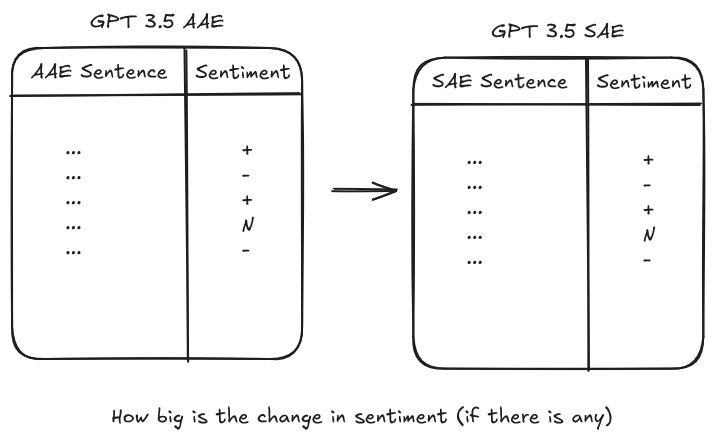

In [10]:
import pandas as pd

anthropic_aae = pd.read_csv('./labeled/anthropic_Haiku-aae-labels.csv')
anthropic_sae = pd.read_csv('./labeled/anthropic_Haiku-sae-labels.csv')

gpt_aae = pd.read_csv('./labeled/gpt-3.5-aae-labels.csv')
gpt_sae = pd.read_csv('./labeled/gpt-3.5-sae-labels.csv')

phi_aae = pd.read_csv('./labeled/Phi-3-aae-labels.csv')
phi_sae = pd.read_csv('./labeled/Phi-3-sae-labels.csv')

## We'll use accuracy as measure of change in model's behaviour for AAE vs SAE

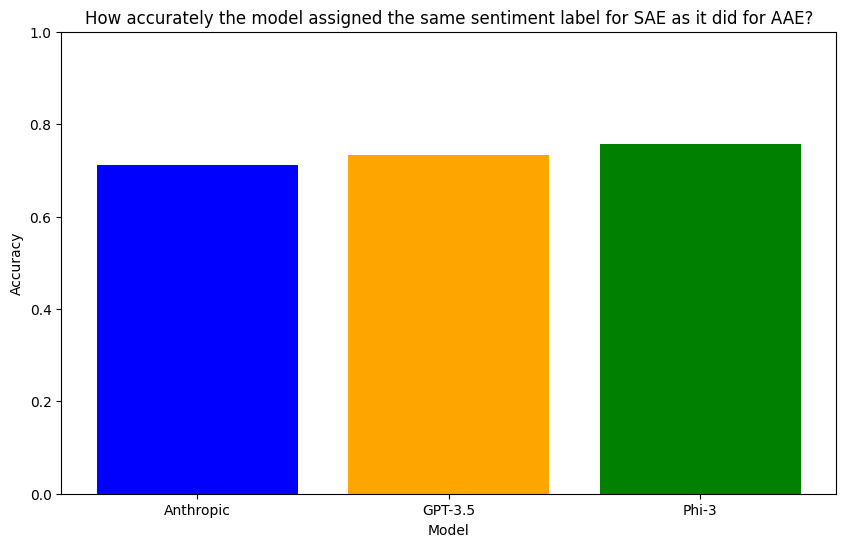

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def calculate_accuracy(true_labels, predicted_labels):
    return accuracy_score(true_labels, predicted_labels)

# Compute accuracy scores
accuracies = {
    'Anthropic': calculate_accuracy(anthropic_aae['sentiment'], anthropic_sae['sae_labels']),
    'GPT-3.5': calculate_accuracy(gpt_aae['sentiment'], gpt_sae['sae_labels']),
    'Phi-3': calculate_accuracy(phi_aae['sentiment'], phi_sae['sae_labels'])
}

# Plotting the bar chart
plt.figure(figsize=(10, 6))
models = list(accuracies.keys())
scores = list(accuracies.values())

plt.bar(models, scores, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('How accurately the model assigned the same sentiment label for SAE as it did for AAE?')
plt.ylim(0, 1)
plt.show()

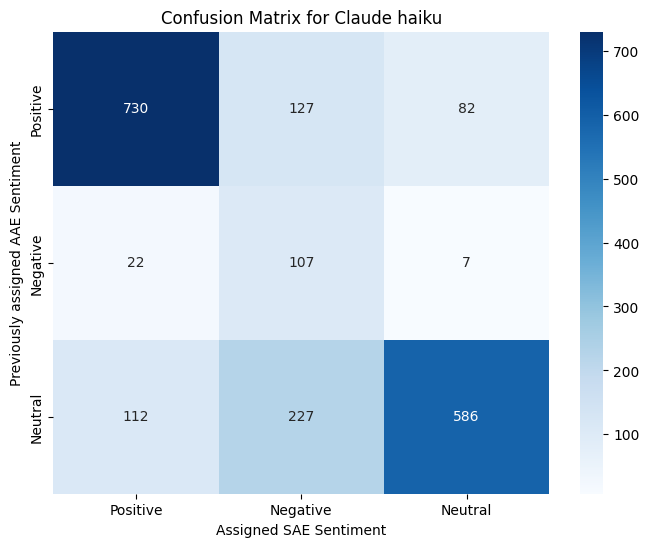

In [20]:
from sklearn.metrics import cohen_kappa_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Example: Calculating Cohen's Kappa
kappa_scores = {
    'Claude Haiku': cohen_kappa_score(anthropic_aae['sentiment'], anthropic_sae['sae_labels']),
    'GPT-3.5': cohen_kappa_score(gpt_aae['sentiment'], gpt_sae['sae_labels']),
    'Phi-3': cohen_kappa_score(phi_aae['sentiment'], phi_sae['sae_labels'])
}

# Example: Class-specific F1-score, precision, recall
f1_scores = {
    'Claude Haiku': precision_recall_fscore_support(anthropic_aae['sentiment'], anthropic_sae['sae_labels'], average=None),
    'GPT-3.5': precision_recall_fscore_support(gpt_aae['sentiment'], gpt_sae['sae_labels'], average=None),
    'Phi-3': precision_recall_fscore_support(phi_aae['sentiment'], phi_sae['sae_labels'], average=None)
}

# Example: Confusion Matrix for a specific model
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(anthropic_aae['sentiment'], anthropic_sae['sae_labels'])
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=sentiment_classes, yticklabels=sentiment_classes)
plt.xlabel('Assigned SAE Sentiment')
plt.ylabel('Previously assigned AAE Sentiment')
plt.title('Confusion Matrix for Claude haiku')
plt.show()


## &#8593; The above confusion matrix shows whether Claude Haiku stick to the same sentiment it assigned to AAE after SAE conversion 

In [1]:
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(gpt_aae['sentiment'], gpt_sae['sae_labels'])
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=sentiment_classes, yticklabels=sentiment_classes)
plt.xlabel('Assigned SAE Sentiment')
plt.ylabel('Previously assigned AAE Sentiment')
plt.title('Confusion Matrix for GPT 3.5')
plt.show()

NameError: name 'plt' is not defined

## &#8593; The above confusion matrix shows whether GPT 3.5 stick to the same sentiment it assigned to AAE after SAE conversion 

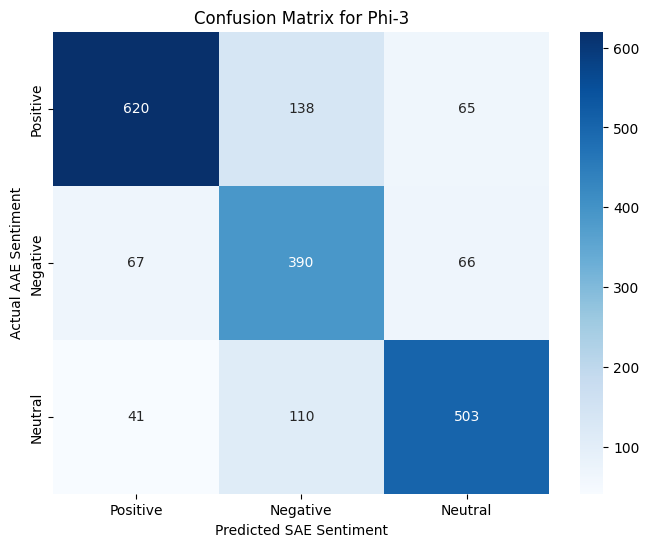

In [17]:
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(phi_aae['sentiment'], phi_sae['sae_labels'])
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=sentiment_classes, yticklabels=sentiment_classes)
plt.xlabel('Assigned SAE Sentiment')
plt.ylabel('Previously assigned AAE Sentiment')
plt.title('Confusion Matrix for Phi-3')
plt.show()

## &#8593; The above confusion matrix shows whether Phi-3 stick to the same sentiment it assigned to AAE after SAE conversion 

________________

# AAE -> SAE -> Back to AAE

In [2]:
anthropic_aae_from_sae = pd.read_csv('./labeled/anthropic_Haiku-AAE_from_SAE_updated_sentiment.csv')
gpt_aae_from_sae = pd.read_csv('./labeled/gpt-3.5-AAE_from_SAE_updated_sentiment.csv')
phi_aae_from_sae = pd.read_csv('./labeled/Phi-3-AAE_from_SAE_sentiment.csv')

NameError: name 'pd' is not defined

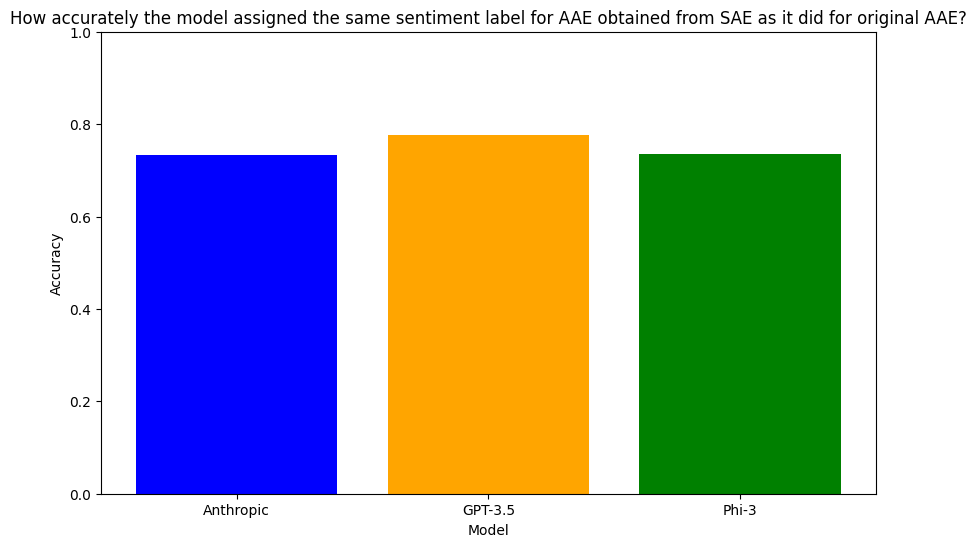

In [25]:
# Compute accuracy scores
accuracies = {
    'Anthropic': calculate_accuracy(anthropic_aae['sentiment'], anthropic_aae_from_sae['sentiment']),
    'GPT-3.5': calculate_accuracy(gpt_aae['sentiment'], gpt_aae_from_sae['sentiment']),
    'Phi-3': calculate_accuracy(phi_aae['sentiment'], phi_aae_from_sae['sentiment'])
}

# Plotting the bar chart
plt.figure(figsize=(10, 6))
models = list(accuracies.keys())
scores = list(accuracies.values())

plt.bar(models, scores, color=['blue', 'orange', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('How accurately the model assigned the same sentiment label for AAE obtained from SAE as it did for original AAE?')
plt.ylim(0, 1)
plt.show()

## &#8593; The accuracy bar plot show how accurately the model assigned the same sentiment label for AAE obtained from SAE as it did for original AAE?

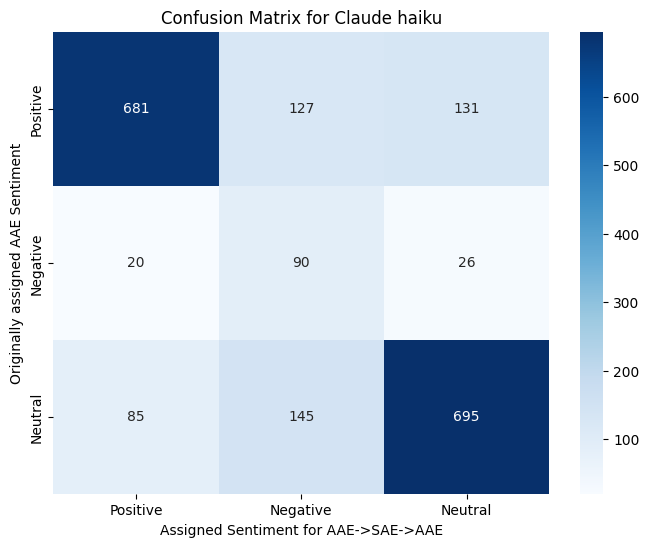

In [27]:
# Example: Confusion Matrix for a specific model
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(anthropic_aae['sentiment'], anthropic_aae_from_sae['sentiment'])
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=sentiment_classes, yticklabels=sentiment_classes)
plt.xlabel('Assigned Sentiment for AAE->SAE->AAE')
plt.ylabel('Originally assigned AAE Sentiment')
plt.title('Confusion Matrix for Claude haiku')
plt.show()


## &#8593; The above confusion matrix shows whether Claude Haiku stick to the same sentiment it assigned to AAE after AAE->SAE->AAE conversion 

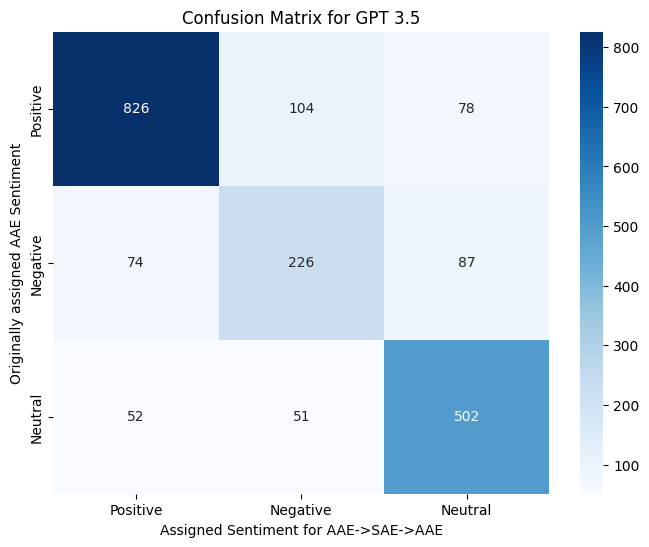

In [28]:
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(gpt_aae['sentiment'], gpt_aae_from_sae['sentiment'])
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=sentiment_classes, yticklabels=sentiment_classes)
plt.xlabel('Assigned Sentiment for AAE->SAE->AAE')
plt.ylabel('Originally assigned AAE Sentiment')
plt.title('Confusion Matrix for GPT 3.5')
plt.show()

## &#8593; The above confusion matrix shows whether GPT 3.5 stick to the same sentiment it assigned to AAE after AAE->SAE->AAE conversion 

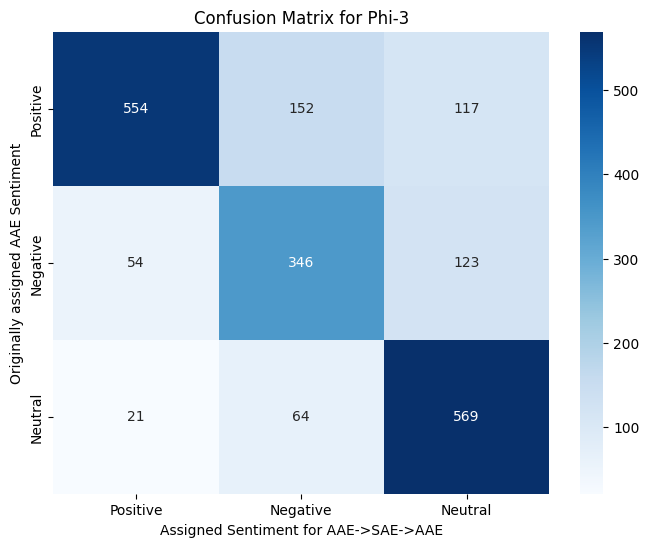

In [29]:
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(phi_aae['sentiment'], phi_aae_from_sae['sentiment'])
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=sentiment_classes, yticklabels=sentiment_classes)
plt.xlabel('Assigned Sentiment for AAE->SAE->AAE')
plt.ylabel('Originally assigned AAE Sentiment')
plt.title('Confusion Matrix for Phi-3')
plt.show()

## &#8593; The above confusion matrix shows whether Phi-3 stick to the same sentiment it assigned to AAE after AAE->SAE->AAE conversion 